## Ref

- https://www.kaggle.com/c/web-traffic-time-series-forecasting
- https://www.kaggle.com/screech/ensemble-of-arima-and-lstm-model-for-wiki-pages
- https://www.kaggle.com/arjunsurendran/using-lstm-on-training-data



In [1]:
# ops 
import numpy as np
import pandas as pd 
import datetime as dt
import time
import math 
import re
import matplotlib.pylab as plt



# DL 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

Using TensorFlow backend.
/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## 0) Get data 

In [2]:
train = pd.read_csv('train_1.csv').fillna(0)


## 1) Data Pre-process

In [15]:
# help functions 

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        """
        ----- fix here for python 3 ----
        https://stackoverflow.com/questions/18493677/how-do-i-return-a-string-from-a-regex-match-in-python
        """
        return res.group(0)[:2]
    return 'na'


def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

    
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
train['lang'] = train.Page.map(get_language)


In [5]:
lang_sets = {}     # get the search data without language column 
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}         # avg daily searching (for each language )
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

In [6]:
train.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh


## 2) Simple LSTM model 

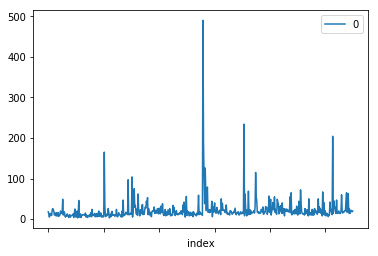

In [7]:
train.iloc[0]\
  .fillna(0)\
  .reset_index()\
  .set_index('index')\
  .iloc[1:-1,:].plot()  # remove language column 

    

### 2-0) Dataset

In [14]:
sums

{'de': 2015-07-01     714.968405
 2015-07-02     705.229741
 2015-07-03     676.877231
 2015-07-04     621.145145
 2015-07-05     722.076185
 2015-07-06     794.832480
 2015-07-07     770.814256
 2015-07-08     782.077641
 2015-07-09     752.939990
 2015-07-10     701.702593
 2015-07-11     649.152963
 2015-07-12     770.119426
 2015-07-13     840.305278
 2015-07-14     799.718876
 2015-07-15     746.422332
 2015-07-16     739.282364
 2015-07-17     760.885965
 2015-07-18     895.272119
 2015-07-19     845.221599
 2015-07-20     774.520462
 2015-07-21     722.307867
 2015-07-22     736.908557
 2015-07-23     715.858845
 2015-07-24     678.896803
 2015-07-25     674.856904
 2015-07-26     705.361514
 2015-07-27     755.171133
 2015-07-28     749.160511
 2015-07-29     747.244514
 2015-07-30     714.238691
                  ...     
 2016-12-02     825.306950
 2016-12-03     783.591848
 2016-12-04     918.928182
 2016-12-05     896.042756
 2016-12-06     859.140724
 2016-12-07     853.21

### 2-1) Train with `train data`, predict with `test-data only  ( lookback)`
    - Dataset : Average Daily Searching (for each language )

In [62]:
sums.keys()

dict_keys(['en', 'es', 'fr', 'ja', 'de', 'na', 'zh', 'ru'])

language :  en
-------
train_size :  368
test_size :  182
-------


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Epoch 1/20
 - 8s - loss: 0.0126
Epoch 2/20
 - 2s - loss: 0.0070
Epoch 3/20
 - 1s - loss: 0.0060
Epoch 4/20
 - 2s - loss: 0.0050
Epoch 5/20
 - 2s - loss: 0.0042
Epoch 6/20
 - 2s - loss: 0.0036
Epoch 7/20
 - 2s - loss: 0.0032
Epoch 8/20
 - 1s - loss: 0.0030
Epoch 9/20
 - 1s - loss: 0.0028
Epoch 10/20
 - 1s - loss: 0.0028
Epoch 11/20
 - 2s - loss: 0.0028
Epoch 12/20
 - 1s - loss: 0.0027
Epoch 13/20
 - 1s - loss: 0.0027
Epoch 14/20
 - 2s - loss: 0.0028
Epoch 15/20
 - 1s - loss: 0.0027
Epoch 16/20
 - 1s - loss: 0.0028
Epoch 17/20
 - 1s - loss: 0.0027
Epoch 18/20
 - 1s - loss: 0.0027
Epoch 19/20
 - 1s - loss: 0.0027
Epoch 20/20
 - 1s - loss: 0.0027


No handles with labels found to put in legend.


Train Score: 272.70 RMSE
Test Score: 477.58 RMSE


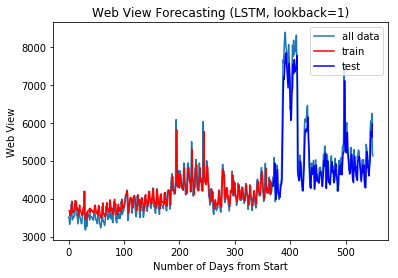

language :  es
-------
train_size :  368
test_size :  182
-------
Epoch 1/20
 - 11s - loss: 0.0927
Epoch 2/20
 - 2s - loss: 0.0233
Epoch 3/20
 - 2s - loss: 0.0202
Epoch 4/20
 - 1s - loss: 0.0175
Epoch 5/20
 - 1s - loss: 0.0150
Epoch 6/20
 - 2s - loss: 0.0131
Epoch 7/20
 - 1s - loss: 0.0115
Epoch 8/20
 - 2s - loss: 0.0106
Epoch 9/20
 - 2s - loss: 0.0099
Epoch 10/20
 - 1s - loss: 0.0097
Epoch 11/20
 - 1s - loss: 0.0096
Epoch 12/20
 - 1s - loss: 0.0095
Epoch 13/20
 - 1s - loss: 0.0095
Epoch 14/20
 - 2s - loss: 0.0096
Epoch 15/20
 - 2s - loss: 0.0096
Epoch 16/20
 - 2s - loss: 0.0095
Epoch 17/20
 - 1s - loss: 0.0095
Epoch 18/20
 - 1s - loss: 0.0095
Epoch 19/20
 - 1s - loss: 0.0095
Epoch 20/20
 - 1s - loss: 0.0095


No handles with labels found to put in legend.


Train Score: 143.79 RMSE
Test Score: 149.61 RMSE


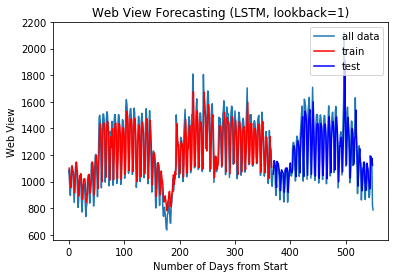

language :  fr
-------
train_size :  368
test_size :  182
-------
Epoch 1/20
 - 6s - loss: 0.0858
Epoch 2/20
 - 1s - loss: 0.0275
Epoch 3/20
 - 1s - loss: 0.0239
Epoch 4/20
 - 1s - loss: 0.0212
Epoch 5/20
 - 2s - loss: 0.0184
Epoch 6/20
 - 2s - loss: 0.0157
Epoch 7/20
 - 2s - loss: 0.0132
Epoch 8/20
 - 1s - loss: 0.0109
Epoch 9/20
 - 1s - loss: 0.0090
Epoch 10/20
 - 2s - loss: 0.0077
Epoch 11/20
 - 2s - loss: 0.0068
Epoch 12/20
 - 2s - loss: 0.0064
Epoch 13/20
 - 2s - loss: 0.0062
Epoch 14/20
 - 2s - loss: 0.0061
Epoch 15/20
 - 3s - loss: 0.0062
Epoch 16/20
 - 3s - loss: 0.0061
Epoch 17/20
 - 2s - loss: 0.0061
Epoch 18/20
 - 2s - loss: 0.0060
Epoch 19/20
 - 2s - loss: 0.0061
Epoch 20/20
 - 2s - loss: 0.0060


No handles with labels found to put in legend.


Train Score: 56.12 RMSE
Test Score: 60.71 RMSE


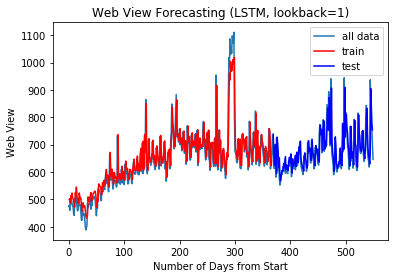

language :  ja
-------
train_size :  368
test_size :  182
-------
Epoch 1/20
 - 9s - loss: 0.0259
Epoch 2/20
 - 2s - loss: 0.0105
Epoch 3/20
 - 2s - loss: 0.0092
Epoch 4/20
 - 2s - loss: 0.0082
Epoch 5/20
 - 2s - loss: 0.0076
Epoch 6/20
 - 2s - loss: 0.0072
Epoch 7/20
 - 2s - loss: 0.0069
Epoch 8/20
 - 2s - loss: 0.0068
Epoch 9/20
 - 2s - loss: 0.0066
Epoch 10/20
 - 2s - loss: 0.0067
Epoch 11/20
 - 2s - loss: 0.0067
Epoch 12/20
 - 2s - loss: 0.0066
Epoch 13/20
 - 2s - loss: 0.0067
Epoch 14/20
 - 1s - loss: 0.0067
Epoch 15/20
 - 1s - loss: 0.0067
Epoch 16/20
 - 2s - loss: 0.0066
Epoch 17/20
 - 2s - loss: 0.0067
Epoch 18/20
 - 1s - loss: 0.0067
Epoch 19/20
 - 1s - loss: 0.0067
Epoch 20/20
 - 1s - loss: 0.0066


No handles with labels found to put in legend.


Train Score: 80.86 RMSE
Test Score: 83.58 RMSE


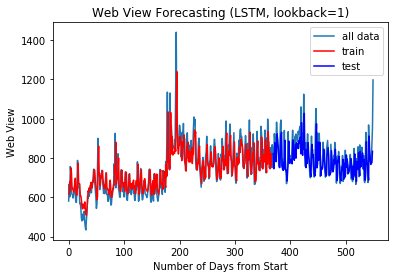

language :  de
-------
train_size :  368
test_size :  182
-------
Epoch 1/20
 - 6s - loss: 0.0501
Epoch 2/20
 - 1s - loss: 0.0175
Epoch 3/20
 - 1s - loss: 0.0155
Epoch 4/20
 - 1s - loss: 0.0143
Epoch 5/20
 - 1s - loss: 0.0132
Epoch 6/20
 - 1s - loss: 0.0125
Epoch 7/20
 - 1s - loss: 0.0123
Epoch 8/20
 - 1s - loss: 0.0120
Epoch 9/20
 - 1s - loss: 0.0119
Epoch 10/20
 - 1s - loss: 0.0120
Epoch 11/20
 - 1s - loss: 0.0118
Epoch 12/20
 - 1s - loss: 0.0118
Epoch 13/20
 - 2s - loss: 0.0117
Epoch 14/20
 - 2s - loss: 0.0117
Epoch 15/20
 - 1s - loss: 0.0117
Epoch 16/20
 - 2s - loss: 0.0117
Epoch 17/20
 - 1s - loss: 0.0118
Epoch 18/20
 - 1s - loss: 0.0118
Epoch 19/20
 - 1s - loss: 0.0118
Epoch 20/20
 - 1s - loss: 0.0117


No handles with labels found to put in legend.


Train Score: 71.21 RMSE
Test Score: 76.09 RMSE


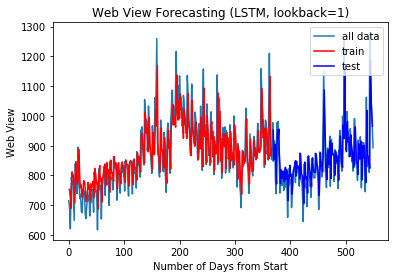

language :  na
-------
train_size :  368
test_size :  182
-------
Epoch 1/20
 - 7s - loss: 0.0199
Epoch 2/20
 - 1s - loss: 0.0112
Epoch 3/20
 - 1s - loss: 0.0096
Epoch 4/20
 - 2s - loss: 0.0079
Epoch 5/20
 - 2s - loss: 0.0063
Epoch 6/20
 - 2s - loss: 0.0049
Epoch 7/20
 - 1s - loss: 0.0039
Epoch 8/20
 - 1s - loss: 0.0034
Epoch 9/20
 - 1s - loss: 0.0030
Epoch 10/20
 - 1s - loss: 0.0031
Epoch 11/20
 - 1s - loss: 0.0031
Epoch 12/20
 - 1s - loss: 0.0031
Epoch 13/20
 - 1s - loss: 0.0030
Epoch 14/20
 - 1s - loss: 0.0031
Epoch 15/20
 - 1s - loss: 0.0031
Epoch 16/20
 - 1s - loss: 0.0030
Epoch 17/20
 - 1s - loss: 0.0031
Epoch 18/20
 - 1s - loss: 0.0031
Epoch 19/20
 - 1s - loss: 0.0031
Epoch 20/20
 - 1s - loss: 0.0031


No handles with labels found to put in legend.


Train Score: 15.55 RMSE
Test Score: 33.17 RMSE


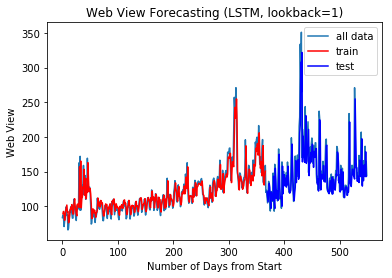

language :  zh
-------
train_size :  368
test_size :  182
-------
Epoch 1/20
 - 7s - loss: 0.0189
Epoch 2/20
 - 1s - loss: 0.0072
Epoch 3/20
 - 1s - loss: 0.0060
Epoch 4/20
 - 1s - loss: 0.0051
Epoch 5/20
 - 1s - loss: 0.0045
Epoch 6/20
 - 1s - loss: 0.0043
Epoch 7/20
 - 1s - loss: 0.0042
Epoch 8/20
 - 1s - loss: 0.0042
Epoch 9/20
 - 1s - loss: 0.0041
Epoch 10/20
 - 1s - loss: 0.0041
Epoch 11/20
 - 1s - loss: 0.0041
Epoch 12/20
 - 1s - loss: 0.0041
Epoch 13/20
 - 1s - loss: 0.0041
Epoch 14/20
 - 2s - loss: 0.0041
Epoch 15/20
 - 1s - loss: 0.0041
Epoch 16/20
 - 1s - loss: 0.0040
Epoch 17/20
 - 2s - loss: 0.0041
Epoch 18/20
 - 2s - loss: 0.0041
Epoch 19/20
 - 1s - loss: 0.0041
Epoch 20/20
 - 1s - loss: 0.0040


No handles with labels found to put in legend.


Train Score: 28.82 RMSE
Test Score: 32.60 RMSE


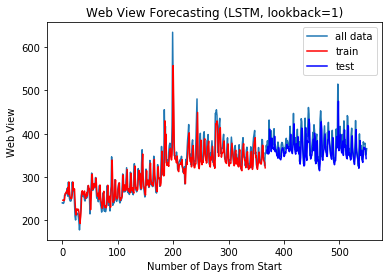

language :  ru
-------
train_size :  368
test_size :  182
-------
Epoch 1/20
 - 9s - loss: 0.0059
Epoch 2/20
 - 2s - loss: 0.0024
Epoch 3/20
 - 1s - loss: 0.0021
Epoch 4/20
 - 1s - loss: 0.0018
Epoch 5/20
 - 1s - loss: 0.0015
Epoch 6/20
 - 2s - loss: 0.0013
Epoch 7/20
 - 2s - loss: 0.0012
Epoch 8/20
 - 1s - loss: 0.0010
Epoch 9/20
 - 1s - loss: 9.7213e-04
Epoch 10/20
 - 1s - loss: 9.1138e-04
Epoch 11/20
 - 1s - loss: 8.6961e-04
Epoch 12/20
 - 1s - loss: 8.4643e-04
Epoch 13/20
 - 1s - loss: 8.5822e-04
Epoch 14/20
 - 1s - loss: 8.4431e-04
Epoch 15/20
 - 2s - loss: 8.3456e-04
Epoch 16/20
 - 2s - loss: 8.5540e-04
Epoch 17/20
 - 2s - loss: 8.5046e-04
Epoch 18/20
 - 2s - loss: 8.4671e-04
Epoch 19/20
 - 2s - loss: 8.4060e-04
Epoch 20/20
 - 2s - loss: 8.2504e-04


No handles with labels found to put in legend.


Train Score: 69.87 RMSE
Test Score: 199.88 RMSE


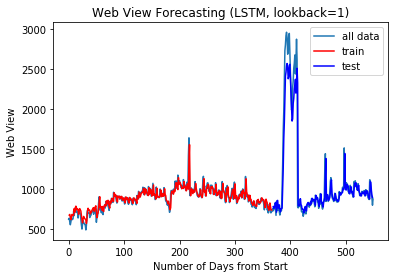

In [66]:
for language in sums.keys():
    print ('language : ', language)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(sums[language].reshape(-1, 1))
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    print ('-------')
    print ('train_size : ', train_size)
    print ('test_size : ', test_size)
    print ('-------')
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    #plot
    series,=plt.plot(scaler.inverse_transform(dataset)[:,])  
    prediccion_entrenamiento,=plt.plot(trainPredictPlot[:,],color = 'red')  
    prediccion_test,=plt.plot(testPredictPlot[:,],color = 'blue')
    plt.title('Web View Forecasting (LSTM, lookback=1)')
    plt.xlabel('Number of Days from Start')
    plt.ylabel('Web View')
    plt.legend()
    plt.legend([serie,prediccion_entrenamiento,prediccion_test],['all data','train','test'], loc='upper right')
    plt.show()




### 2-2) Train with `train-data`, predict with `whole dataset (train+test data) (no lookback)`

    - Dataset : Average Daily Searching (for each language )

en


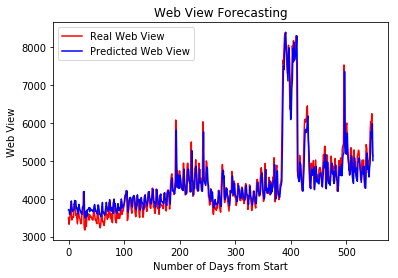

es


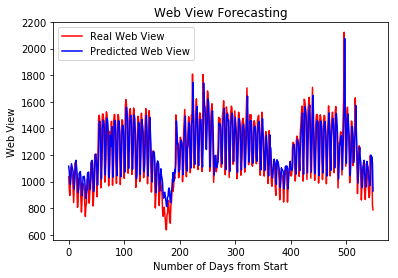

fr


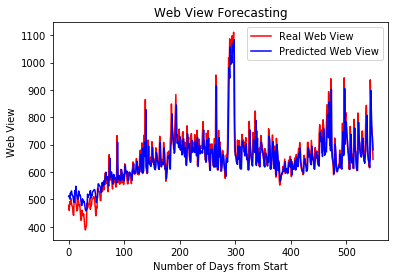

ja


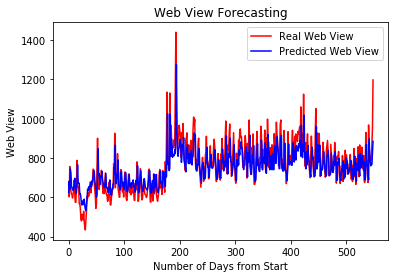

de


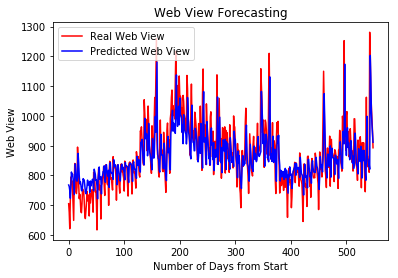

na


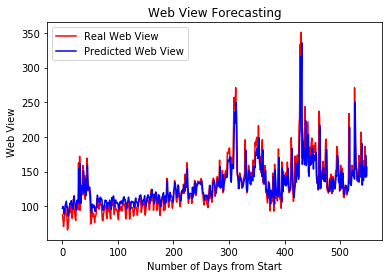

zh


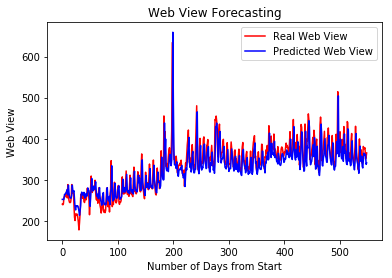

ru


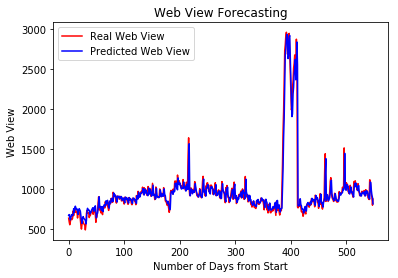

In [12]:
### Here we are predicting "average daily searching (for each language )" ; insead of each single wiki searching  
### TODO : validate if it makes sense to "train LSTM with test data, but doing prediction with whole test + train data" ?    

for key in sums:
    row = [0]*sums[key].shape[0]
    for i in range(sums[key].shape[0]):
        row[i] = sums[key][i]


    #Using Data From Random Row for Training and Testing

    X = row[0:549]
    y = row[1:550]

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    # Feature Scaling
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,1))
    y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
    y_train = sc.fit_transform(y_train)


    #Training LSTM

    #Reshaping Array
    X_train = np.reshape(X_train, (384,1,1))

    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))


    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

    # Getting the predicted Web View
    
    # --- NEED TO VALIDATE HERE --- #
    
    inputs = X
    inputs = np.reshape(inputs,(-1,1))
    inputs = sc.transform(inputs)
    inputs = np.reshape(inputs, (549,1,1))
    y_pred = regressor.predict(inputs)
    y_pred = sc.inverse_transform(y_pred)
    
    # --- NEED TO VALIDATE HERE --- #
    

    print(key)
    #Visualising Result
    plt.figure
    plt.plot(y, color = 'red', label = 'Real Web View')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
    plt.title('Web View Forecasting')
    plt.xlabel('Number of Days from Start')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()